## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import & 사용될 함수작성

In [12]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)



# 2. 데이터 불러오기

In [13]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/LG AI대회/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#데이터 모두 불러옴

train_err  = pd.read_csv(PATH+'train_err_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')

train_problem  = pd.read_csv(PATH+'train_problem_data.csv')

train_quality  = pd.read_csv(PATH+'train_quality_data.csv')

test_quality  = pd.read_csv(PATH+'test_quality_data.csv')

sample_submission = pd.read_csv(PATH+'sample_submission.csv')

#(변수1)error_type별 빈도수인 DataFrame만들기

In [15]:
#error_type1만들기(일별 err_type별 도수)

#index = user_id , columns = errtype, value = 에러발생빈도수 인 피벗테이블 만들기

train_err['count'] = 1 #pivot테이블에서 계산을 위한 변수 1 추가
#피벗테이블 만들기
error_type1 = pd.pivot_table(train_err, values = 'count', index = 'user_id', columns = 'errtype',aggfunc = 'sum')
error_type1[29] = 0 #데이터에 29인 errtype이 없으므로 전부 0으로 하는 열 하나를 추가해줌
error_type1 = error_type1.reindex(columns = sorted(error_type1.columns)) #errtype을 오름차순으로 정리
error_type1.fillna(0, inplace=True) #na값은 0으로 바꿔줌

error_type1.head()


errtype,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,15.0,16.0,1.0,10.0,59.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,10.0,11.0,1.0,15.0,151.0,128.0,0.0,4.0,1.0,3.0,1.0,756.0,751.0,5.0,1.0,22.0,0.0,0.0,0,0.0,250.0,0.0,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0
10002,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,13.0,14.0,1.0,4.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,25.0,2.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10003,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,52.0,30.0,1.0,0.0,0.0,0.0,0.0,28.0,19.0,0.0,0.0,59.0,0.0,0.0,0,0.0,65.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0
10004,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,16.0,19.0,3.0,5.0,143.0,91.0,0.0,0.0,0.0,0.0,0.0,140.0,119.0,0.0,0.0,33.0,0.0,0.0,0,0.0,176.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0


error_type1_1만들기(일부 err_type만 발췌)

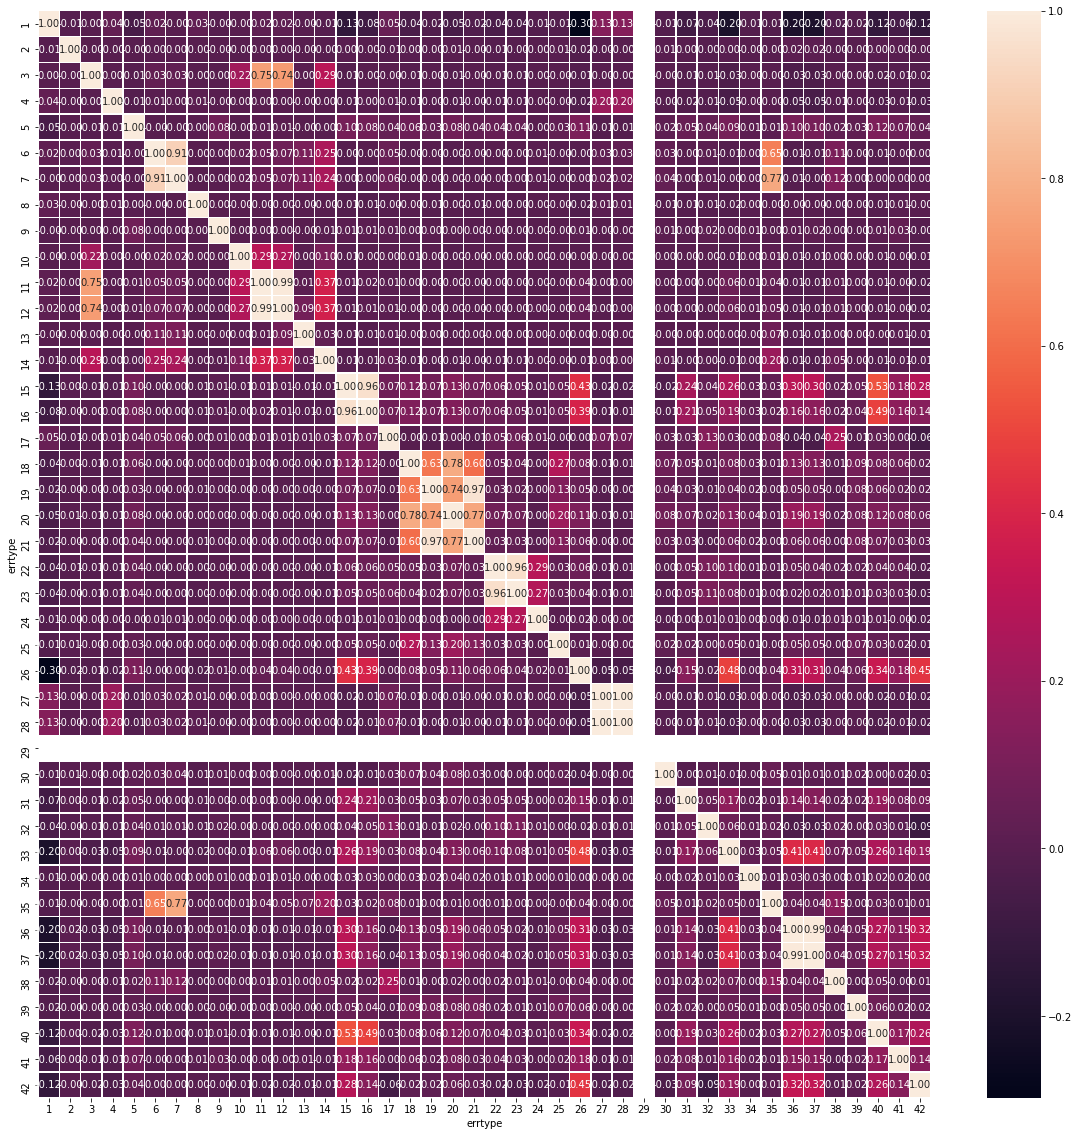

In [17]:
#cols = ['errtype1', 'errtype2', 'errtype3', 'errtype4', 'errtype5',
#       'errtype6', 'errtype7', 'errtype8', 'errtype9', 'errtype10',
#       'errtype11', 'errtype12', 'errtype13', 'errtype14', 'errtype15',
#       'errtype16', 'errtype17', 'errtype18', 'errtype19', 'errtype20',
#       'errtype21', 'errtype22', 'errtype23', 'errtype24', 'errtype25',
#       'errtype26', 'errtype27', 'errtype28', 'errtype30', 'errtype31',
#       'errtype32', 'errtype33', 'errtype34', 'errtype35', 'errtype36',
#       'errtype37', 'errtype38', 'errtype39', 'errtype40', 'errtype41',
#       'errtype42']

#히트맵 그려서 err_type간의 관계확인
cols = range(1,43)
plt.figure(figsize=(20,20))
sns.heatmap(error_type1[cols].fillna(0).corr(), annot=True, fmt = '.2f', linewidths=.5)

In [106]:
print(error_type1[29].value_counts().sort_index()) #29번은 전부 0이니까 빼겠음
print('\n')
#이런식으로 대충의 경향성은 볼 수 있음(또는 아래의 산점도)
for i in range(1,43):
  print(error_type1[i].value_counts().sort_index())
  print(error_type1[i].value_counts().sort_values(ascending = False))
  print('\n')



0    15000
Name: 29, dtype: int64


0.0      14050
1.0        232
2.0         31
3.0          8
4.0          3
         ...  
115.0        1
125.0        2
126.0        1
154.0        1
171.0        1
Name: 1, Length: 81, dtype: int64
0.0     14050
30.0      278
1.0       232
31.0       80
29.0       49
        ...  
73.0        1
56.0        1
8.0         1
40.0        1
66.0        1
Name: 1, Length: 81, dtype: int64


0.0       14610
1.0           2
2.0         231
4.0          50
6.0          14
          ...  
1680.0        1
2021.0        1
2280.0        1
3724.0        1
4056.0        1
Name: 2, Length: 63, dtype: int64
0.0      14610
2.0        231
4.0         50
6.0         14
8.0         12
         ...  
76.0         1
68.0         1
70.0         1
160.0        1
556.0        1
Name: 2, Length: 63, dtype: int64


0.0       13321
1.0         614
2.0         258
3.0         146
4.0         240
          ...  
1260.0        1
1440.0        1
2497.0        1
2838.0        1
7284

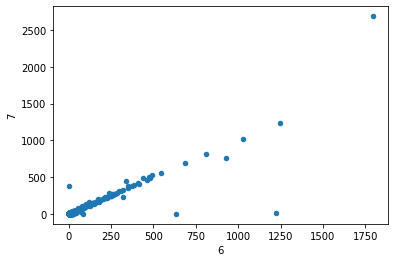

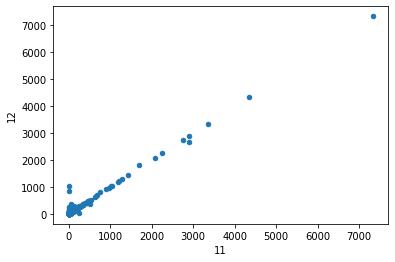

In [76]:
#산점도 그려보기

error_type1.plot(kind = 'scatter', x = 6, y=7)
error_type1.plot(kind = 'scatter', x = 11, y=12)

In [84]:
error_type1_1 = error_type1.drop(columns = [7,12,16,21,23,28,29,37]) #상관계수0.9이상인 칼럼 삭제(뒤에나오는변수 우선적으로 삭제함)
error_tpye1_2 = error_type1_1.drop(columns = [11,20]) #추가적으로 상관계수0.7이상안 칼럼 삭제(뒤에나오는 변수 우선적으로 삭제함)

errtype   1    2    3      4     5    6   ...   36   38   39     40    41   42
user_id                                   ...                                 
10000    0.0  0.0  8.0  104.0   0.0  1.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
10001    0.0  0.0  0.0    0.0  53.0  1.0  ...  1.0  0.0  0.0  113.0  56.0  1.0
10002    0.0  0.0  2.0  132.0   1.0  2.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
10003    0.0  0.0  0.0    0.0   2.0  1.0  ...  1.0  2.0  0.0   17.0   1.0  0.0
10004    0.0  0.0  0.0    1.0   0.0  3.0  ...  1.0  0.0  0.0    4.0   0.0  2.0
...      ...  ...  ...    ...   ...  ...  ...  ...  ...  ...    ...   ...  ...
24995    0.0  0.0  0.0    0.0   2.0  5.0  ...  0.0  0.0  0.0    9.0   7.0  4.0
24996    0.0  0.0  0.0    0.0   0.0  0.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
24997    0.0  0.0  0.0    1.0   8.0  1.0  ...  1.0  0.0  0.0   58.0   8.0  5.0
24998    0.0  0.0  0.0    0.0   0.0  0.0  ...  1.0  0.0  0.0    6.0   0.0  0.0
24999    0.0  0.0  4.0  192.0   7.0  5.0  ...  0.0  

#(변수2)day별 빈도수인 DataFrame만들기

In [18]:
#train_err데이터 셋에 연,월,일,시 변수 만들어 주기
train_err['datetime'] = train_err['time'].apply(make_datetime)
train_err['day'] = train_err.loc[:,'datetime'].dt.day
train_err['month'] = train_err.loc[:,'datetime'].dt.month
train_err['year'] = train_err.loc[:,'datetime'].dt.year
train_err['hour'] = train_err.loc[:,'datetime'].dt.hour

In [19]:
#day1만들기(일별 에러발생 도수)

#index = user_id , columns = [month,day] , value = 에러발생빈도수 인 피벗테이블 만들기

#피벗테이블 만들기
day1 = pd.pivot_table(train_err, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
day1.fillna(0,inplace=True)

#10월31일~12월2일까지의 데이터임(10월과 12월의 에러발생빈도수를 보는중(11월의 다른날들에 비해서 값이 너무 적음))
#print(day1.iloc[:,0].value_counts()) 
#print(day1.iloc[:,31].value_counts())
#print(day1.iloc[:,32].value_counts()) 
#보면 10월31일과 12월1일 12월 2일은 다른 날에 비해서 에러 발생빈도가 엄청나게 적음(나중에 데이터를 빼는것도 고려해봐야할듯)
day1.head()

month     10    11                          ...                             12     
day       31    1     2     3     4     5   ...      27    28    29    30   1    2 
user_id                                     ...                                    
10000    0.0  11.0   9.0  18.0   5.0  10.0  ...    12.0  18.0  13.0   9.0  0.0  0.0
10001    0.0  11.0  50.0  29.0  48.0  42.0  ...  1452.0  38.0  62.0  28.0  0.0  0.0
10002    0.0  10.0  13.0  13.0  15.0   9.0  ...    16.0   0.0   8.0   9.0  0.0  0.0
10003    0.0   9.0  14.0  10.0   5.0  16.0  ...    21.0  11.0  14.0   6.0  0.0  0.0
10004    0.0  25.0  21.0  49.0  28.0  11.0  ...    24.0  18.0  23.0  22.0  0.0  0.0

[5 rows x 33 columns]

In [20]:
#day2만들기(일별 에러발생 누적도수)

#일별 누적도수로 만들기(day1는 그냥 일별도수)

#index = user_id , columns = [month,day] , value = 에러발생빈도수 인 피벗테이블 만들기(의와 같음)
#피벗테이블 만들기
day2 = pd.pivot_table(train_err, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
day2.fillna(0,inplace=True)

#누적도수로 만들기
for i in range(1,day2.shape[1]):
  day2.iloc[:,i] = day2.iloc[:,i-1] + day2.iloc[:,i]

day2.head()

month     10    11                     ...                              12        
day       31    1     2     3      4   ...      28      29      30      1       2 
user_id                                ...                                        
10000    0.0  11.0  20.0  38.0   43.0  ...   295.0   308.0   317.0   317.0   317.0
10001    0.0  11.0  61.0  90.0  138.0  ...  2275.0  2337.0  2365.0  2365.0  2365.0
10002    0.0  10.0  23.0  36.0   51.0  ...   289.0   297.0   306.0   306.0   306.0
10003    0.0   9.0  23.0  33.0   38.0  ...   286.0   300.0   306.0   306.0   306.0
10004    0.0  25.0  46.0  95.0  123.0  ...   732.0   755.0   777.0   777.0   777.0

[5 rows x 33 columns]

#(변수3)quality 별 빈도수인 DataFrame만들기


In [21]:
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')
#train_quality데이터 셋에 연,월,일,시 변수 만들어 주기
train_quality['datetime'] = train_quality['time'].apply(make_datetime)
train_quality['day'] = train_quality.loc[:,'datetime'].dt.day
train_quality['month'] = train_quality.loc[:,'datetime'].dt.month
train_quality['year'] = train_quality.loc[:,'datetime'].dt.year
train_quality['hour'] = train_quality.loc[:,'datetime'].dt.hour

In [22]:
quality = train_quality
quality.info()
quality.fillna(0) #quality_5변수에 NA값이 있음

#quality의 문자열변수,정수형변수 -> 실수형으로 바꿔주기
cols = ['quality_0', 'quality_1', 'quality_2','quality_3', 'quality_4', 'quality_5', 
        'quality_6', 'quality_7','quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']
quality[cols] = quality[cols].replace({',':''}, regex= True) #2,345이런식으로 표현된(문자열) 원소들이 있음
quality.iloc[:,3:16] = quality.iloc[:,3:16].astype(float) #quality_n 변수들 실수형으로 바꿔주기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828624 entries, 0 to 828623
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        828624 non-null  int64         
 1   user_id     828624 non-null  int64         
 2   fwver       788544 non-null  object        
 3   quality_0   684192 non-null  float64       
 4   quality_1   828624 non-null  int64         
 5   quality_2   788511 non-null  float64       
 6   quality_3   828624 non-null  int64         
 7   quality_4   828624 non-null  int64         
 8   quality_5   828604 non-null  object        
 9   quality_6   828624 non-null  int64         
 10  quality_7   828624 non-null  object        
 11  quality_8   828624 non-null  object        
 12  quality_9   828624 non-null  object        
 13  quality_10  828624 non-null  object        
 14  quality_11  828624 non-null  int64         
 15  quality_12  828624 non-null  int64         
 16  da

quality1 만들기

In [23]:
#quality1만들기(quality의 일별 합)

quality = quality.drop_duplicates() #중복되는 행 모두제거(모든열에 대해서)

quality1 = quality.groupby(['user_id','month','day'])[cols].max() #규칙을찾음(무조건은 아님)
#규칙: quality변수중 가장 큰 원소값(max)을 가지는것이 그 시간대의 누적quality합임

qsum = []
#위 규칙대로 각 개체별 최대값을 qsum이라는 변수로 만듦
for i in range(0,len(quality1)):
  qsum.append(quality1.iloc[i].max())
quality1['qsum'] = qsum
quality1.head()

quality_0  quality_1  ...  quality_12  qsum
user_id month day                        ...                  
10000   11    29         0.0        0.0  ...         0.0   4.0
              30         0.0        0.0  ...         0.0   8.0
10002   11    4          2.0        0.0  ...         0.0   2.0
              6          0.0        0.0  ...         0.0   2.0
              11         0.0        0.0  ...         0.0   4.0

[5 rows x 14 columns]

In [24]:
quality1 = quality1.reset_index() #인덱스들을 변수로 빼내기

#index = user_id , columns = [month,day] , value = quality발생합 인 피벗테이블 만들기
#피벗테이블 만들기
quality1 = pd.pivot_table(quality1, values = 'qsum', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
quality1.fillna(0, inplace=True) #na를 0으로 채움
quality1.head()

month     10   11                            ...                                   
day       31   1    2    3     4    5    6   ...   24   25   26   27   28   29   30
user_id                                      ...                                   
10000    0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  4.0  8.0
10002    0.0  0.0  0.0  0.0   2.0  0.0  2.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  8.0
10004    0.0  0.0  3.0  0.0  87.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10005    0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10006    0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0  4.0  0.0  0.0  0.0

[5 rows x 31 columns]

quality2 만들기

In [25]:
#quality2만들기(quality로그 자체가 발생한 일별 빈도수)

quality2 = train_quality
quality2['count'] = 1

#index = user_id , columns = [month,day] , value = quality로그자체발생빈도수 인 피벗테이블 만들기
#피벗테이블 만들기
quality2 = pd.pivot_table(quality2, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
quality2.fillna(0,inplace=True)
quality2.head()

month     10   11                        ...                                 
day       31   1     2    3     4    5   ...   25   26    27   28    29    30
user_id                                  ...                                 
10000    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0  0.0  12.0  12.0
10002    0.0  0.0   0.0  0.0  12.0  0.0  ...  0.0  0.0   0.0  0.0   0.0  24.0
10004    0.0  0.0  12.0  0.0  12.0  0.0  ...  0.0  0.0   0.0  0.0   0.0   0.0
10005    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0   0.0  0.0   0.0   0.0
10006    0.0  0.0   0.0  0.0   0.0  0.0  ...  0.0  0.0  12.0  0.0   0.0   0.0

[5 rows x 31 columns]

## 데이터 종합(X_train의미) 및 Ndarray로 바꿔주기

In [90]:
#사용할 데이터 모음

#error_type1
#day1
#day2
#quality1
#quality2

#print(error_type1.shape, day1.shape, day2.shape, quality1.shape, quality2.shape)
#print('\n')

master_data = error_type1_1
#master_data = pd.merge(error_type1, day1, left_on='user_id', right_on='user_id', how='left')
#master_data = pd.merge(master_data, day2, left_on='user_id', right_on='user_id', how='left')
#master_data = pd.merge(master_data, quality1, left_on='user_id', right_on='user_id', how='left')
#master_data = pd.merge(master_data, quality2, left_on='user_id', right_on='user_id', how='left')
#master_data.fillna(0, inplace = True)

print(master_data.shape)
print(master_data)
#시간되면 master_data의 .columns 이름 지어주자

MD = master_data.to_numpy()

(15000, 34)
errtype   1    2    3      4     5    6   ...   36   38   39     40    41   42
user_id                                   ...                                 
10000    0.0  0.0  8.0  104.0   0.0  1.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
10001    0.0  0.0  0.0    0.0  53.0  1.0  ...  1.0  0.0  0.0  113.0  56.0  1.0
10002    0.0  0.0  2.0  132.0   1.0  2.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
10003    0.0  0.0  0.0    0.0   2.0  1.0  ...  1.0  2.0  0.0   17.0   1.0  0.0
10004    0.0  0.0  0.0    1.0   0.0  3.0  ...  1.0  0.0  0.0    4.0   0.0  2.0
...      ...  ...  ...    ...   ...  ...  ...  ...  ...  ...    ...   ...  ...
24995    0.0  0.0  0.0    0.0   2.0  5.0  ...  0.0  0.0  0.0    9.0   7.0  4.0
24996    0.0  0.0  0.0    0.0   0.0  0.0  ...  0.0  0.0  0.0    0.0   0.0  0.0
24997    0.0  0.0  0.0    1.0   8.0  1.0  ...  1.0  0.0  0.0   58.0   8.0  5.0
24998    0.0  0.0  0.0    0.0   0.0  0.0  ...  1.0  0.0  0.0    6.0   0.0  0.0
24999    0.0  0.0  4.0  192.0   7.0  5.0

# 2.2 problem (y_train의미)

In [91]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치(user_id가 10000부터 시작하므로)에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
print(problem.shape)
print(problem)

(15000,)
[0. 1. 0. ... 1. 1. 0.]


# 3. Light-gbm 모델 훈련

In [92]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = MD
train_y = problem
print(train_x.shape)
print(train_y.shape)

(15000, 34)
(15000,)


In [93]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015,
                'learning_rate' : 0.4, #default = 0.1,
                'subsample' : 0.8,
                'sub_feature': 0.5,
                'num_leaves' : 31, #default = 31
                'max_bin' : 400, #default =255
                'max_depth': 20, #제한없이 분기
                'min_data_in_leaf' :20, #default = 20
               #'colsample_bytree' : 0.65
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[10]	valid_0's auc: 0.790895	valid_0's pr_auc: 0.78301
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.754808	valid_0's pr_auc: 0.319594
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.760229	valid_0's pr_auc: 0.386475
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.787263	valid_0's pr_auc: 0.521011
Training until validation scores don't improve for 3 rounds.
Early stopping, best iteration is:
[4]	valid_0's auc: 0.788256	valid_0's pr_auc: 0.971904


# 4. 교차검증 점수 확인

In [94]:
print(np.mean(auc_scores))

0.776290049076642


# 5. 제출 파일 생성

In [95]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


In [32]:
#중요 43262인 user_id는 데이터에 없음 -> 즉, 14998개의 데이터임(sameple_submission데이터는 14999개의 데이터임)
43262 in test_err['user_id'].unique() 

False

#위에서 training데이터 만든것처럼 X_test데이터(user_id개수의행 X 170열) 만들어줄것임

In [33]:
#error_type2만들기(일별 err_type별 도수)
'''
#index = user_id , columns = errtype, value = 에러발생빈도수 인 피벗테이블 만들기

test_err['count'] = 1 #pivot테이블에서 계산을 위한 변수 1 추가
#피벗테이블 만들기
error_type2 = pd.pivot_table(test_err, values = 'count', index = 'user_id', columns = 'errtype',aggfunc = 'sum')
error_type2[29] = 0 #데이터에 29인 errtype이 없으므로 전부 0으로 하는 열 하나를 추가해줌
error_type2 = error_type2.reindex(columns = sorted(error_type2.columns)) #errtype을 오름차순으로 정리
error_type2.fillna(0, inplace=True) #na값은 0으로 바꿔줌
error_type2.tail()
'''

"\n#index = user_id , columns = errtype, value = 에러발생빈도수 인 피벗테이블 만들기\n\ntest_err['count'] = 1 #pivot테이블에서 계산을 위한 변수 1 추가\n#피벗테이블 만들기\nerror_type2 = pd.pivot_table(test_err, values = 'count', index = 'user_id', columns = 'errtype',aggfunc = 'sum')\nerror_type2[29] = 0 #데이터에 29인 errtype이 없으므로 전부 0으로 하는 열 하나를 추가해줌\nerror_type2 = error_type2.reindex(columns = sorted(error_type2.columns)) #errtype을 오름차순으로 정리\nerror_type2.fillna(0, inplace=True) #na값은 0으로 바꿔줌\nerror_type2.tail()\n"

In [34]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████| 16532648/16532648 [00:39<00:00, 415715.94it/s]

(14999, 42)


In [96]:
test_x_1 = test_x.drop(columns = [7,12,16,21,23,28,29,37]) #상관계수0.9이상인 칼럼 삭제(뒤에나오는변수 우선적으로 삭제함)
test_x_2 = test_x_1.drop(columns = [11,20]) #추가적으로 상관계수0.7이상안 칼럼 삭제(뒤에나오는 변수 우선적으로 삭제함)

In [35]:
#test_err데이터 셋에 연,월,일,시 변수 만들어 주기
test_err['datetime'] = test_err['time'].apply(make_datetime)
test_err['day'] = test_err.loc[:,'datetime'].dt.day
test_err['month'] = test_err.loc[:,'datetime'].dt.month
test_err['year'] = test_err.loc[:,'datetime'].dt.year
test_err['hour'] = test_err.loc[:,'datetime'].dt.hour

In [36]:
#day3만들기(일별 에러발생 도수)

#index = user_id , columns = [month,day] , value = 에러발생빈도수 인 피벗테이블 만들기

#피벗테이블 만들기
test_err['count'] = 1
day3 = pd.pivot_table(test_err, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
day3.fillna(0,inplace=True)

#10월31일~12월2일까지의 데이터임(10월과 12월의 에러발생빈도수를 보는중(11월의 다른날들에 비해서 값이 너무 적음))
#print(day1.iloc[:,0].value_counts()) 
#print(day1.iloc[:,31].value_counts())
#print(day1.iloc[:,32].value_counts()) 
#보면 10월31일과 12월1일 12월 2일은 다른 날에 비해서 에러 발생빈도가 엄청나게 적음(나중에 데이터를 빼는것도 고려해봐야할듯)
day3.head()

month     10    11                          ...   12                         
day       31    1     2     3     4     5   ...   3    4    5    9    11   14
user_id                                     ...                              
30000    0.0  76.0   2.0   7.0   0.0  24.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
30001    0.0  13.0  18.0   5.0  17.0   4.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
30002    0.0  29.0  18.0  53.0  20.0  30.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
30003    0.0   6.0  11.0  10.0   6.0   4.0  ...  0.0  0.0  0.0  0.0  0.0  0.0
30004    0.0  39.0  28.0  21.0  48.0   8.0  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 39 columns]

In [37]:
#day4만들기(일별 에러발생 누적도수)

#일별 누적도수로 만들기(day1는 그냥 일별도수)

#index = user_id , columns = [month,day] , value = 에러발생빈도수 인 피벗테이블 만들기(위와 같음)
#피벗테이블 만들기
day4 = pd.pivot_table(test_err, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
day4.fillna(0,inplace=True)

#누적도수로 만들기
for i in range(1,day4.shape[1]):
  day4.iloc[:,i] = day4.iloc[:,i-1] + day4.iloc[:,i]

day4.head()

month     10    11                      ...      12                                
day       31    1     2      3      4   ...      4       5       9       11      14
user_id                                 ...                                        
30000    0.0  76.0  78.0   85.0   85.0  ...  2750.0  2750.0  2750.0  2750.0  2750.0
30001    0.0  13.0  31.0   36.0   53.0  ...   284.0   284.0   284.0   284.0   284.0
30002    0.0  29.0  47.0  100.0  120.0  ...   941.0   941.0   941.0   941.0   941.0
30003    0.0   6.0  17.0   27.0   33.0  ...   371.0   371.0   371.0   371.0   371.0
30004    0.0  39.0  67.0   88.0  136.0  ...   881.0   881.0   881.0   881.0   881.0

[5 rows x 39 columns]

In [38]:
test_quality  = pd.read_csv(PATH+'test_quality_data.csv')
#test_quality데이터 셋에 연,월,일,시 변수 만들어 주기
test_quality['datetime'] = test_quality['time'].apply(make_datetime)
test_quality['day'] = test_quality.loc[:,'datetime'].dt.day
test_quality['month'] = test_quality.loc[:,'datetime'].dt.month
test_quality['year'] = test_quality.loc[:,'datetime'].dt.year
test_quality['hour'] = test_quality.loc[:,'datetime'].dt.hour

In [39]:
quality = test_quality
quality.info()
quality.fillna(0) #quality_5변수에 NA값이 있음

#quality의 문자열변수,정수형변수 -> 실수형으로 바꿔주기
cols = ['quality_0', 'quality_1', 'quality_2','quality_3', 'quality_4', 'quality_5', 
        'quality_6', 'quality_7','quality_8', 'quality_9', 'quality_10', 'quality_11', 'quality_12']
quality[cols] = quality[cols].replace({',':''}, regex= True) #2,345이런식으로 표현된(문자열) 원소들이 있음
quality.iloc[:,3:16] = quality.iloc[:,3:16].astype(float) #quality_n 변수들 실수형으로 바꿔주기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747972 entries, 0 to 747971
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        747972 non-null  int64         
 1   user_id     747972 non-null  int64         
 2   fwver       725208 non-null  object        
 3   quality_0   641388 non-null  float64       
 4   quality_1   747961 non-null  object        
 5   quality_2   726857 non-null  float64       
 6   quality_3   747972 non-null  int64         
 7   quality_4   747972 non-null  int64         
 8   quality_5   747928 non-null  object        
 9   quality_6   747972 non-null  int64         
 10  quality_7   747972 non-null  object        
 11  quality_8   747972 non-null  object        
 12  quality_9   747972 non-null  object        
 13  quality_10  747972 non-null  object        
 14  quality_11  747972 non-null  int64         
 15  quality_12  747972 non-null  int64         
 16  da

In [40]:
#quality3만들기(quality의 일별 합)

quality = quality.drop_duplicates() #중복되는 행 모두제거(모든열에 대해서)

quality3 = quality.groupby(['user_id','month','day'])[cols].max() #규칙을찾음(무조건은 아님)
#규칙: quality변수중 가장 큰 원소값(max)을 가지는것이 그 시간대의 누적quality합임

qsum = []
#위 규칙대로 각 개체별 최대값을 qsum이라는 변수로 만듦
for i in range(0,len(quality3)):
  qsum.append(quality3.iloc[i].max())
quality3['qsum'] = qsum
quality3.head()

quality_0  quality_1  ...  quality_12    qsum
user_id month day                        ...                    
30000   11    28         0.0        0.0  ...         0.0     5.0
30001   11    2          0.0        0.0  ...         0.0     3.0
              4          0.0        0.0  ...         0.0     4.0
              12         0.0        0.0  ...         0.0  2556.0
30002   11    1          0.0        0.0  ...         0.0     6.0

[5 rows x 14 columns]

In [41]:
quality3 = quality3.reset_index() #인덱스들을 변수로 빼내기

#index = user_id , columns = [month,day] , value = quality발생합 인 피벗테이블 만들기
#피벗테이블 만들기
quality3 = pd.pivot_table(quality3, values = 'qsum', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
quality3.fillna(0, inplace=True) #na를 0으로 채움
quality3.head()

month     10   11                      ...                                
day       31   1    2    3    4    5   ...    25    26   27   28   29   30
user_id                                ...                                
30000    0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0  0.0  5.0  0.0  0.0
30001    0.0  0.0  3.0  0.0  4.0  0.0  ...   0.0   0.0  0.0  0.0  0.0  0.0
30002    0.0  6.0  0.0  3.0  0.0  0.0  ...   0.0   0.0  0.0  0.0  0.0  0.0
30003    0.0  0.0  0.0  0.0  0.0  0.0  ...  60.0   0.0  0.0  0.0  0.0  0.0
30004    0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  24.0  0.0  0.0  0.0  0.0

[5 rows x 31 columns]

In [42]:
#quality4만들기(quality로그 자체가 발생한 일별 빈도수)

quality4 = test_quality
quality4['count'] = 1

#index = user_id , columns = [month,day] , value = quality로그자체발생빈도수 인 피벗테이블 만들기
#피벗테이블 만들기
quality4 = pd.pivot_table(quality4, values = 'count', index = 'user_id', columns = ['month','day'],aggfunc = 'sum')
quality4.fillna(0,inplace=True)
quality4.head()

month     10    11                         ...                                 
day       31    1     2     3     4    5   ...    25    26   27    28   29   30
user_id                                    ...                                 
30000    0.0   0.0   0.0   0.0   0.0  0.0  ...   0.0   0.0  0.0  12.0  0.0  0.0
30001    0.0   0.0  12.0   0.0  12.0  0.0  ...   0.0   0.0  0.0   0.0  0.0  0.0
30002    0.0  12.0   0.0  12.0   0.0  0.0  ...   0.0   0.0  0.0   0.0  0.0  0.0
30003    0.0   0.0   0.0   0.0   0.0  0.0  ...  12.0   0.0  0.0   0.0  0.0  0.0
30004    0.0   0.0   0.0   0.0   0.0  0.0  ...   0.0  12.0  0.0   0.0  0.0  0.0

[5 rows x 31 columns]

In [97]:
#사용할 데이터 모음

#test_x(error_type2의 대체)
test_x = pd.DataFrame(test_x).reset_index()
test_x = test_x.rename(columns={'index': 'user_id'})
#day3
#day4
#quality3
#quality4

print(test_x.shape, day3.shape, day4.shape, quality3.shape, quality4.shape)
print('\n')

master_data_t = test_x_1
#master_data_t = pd.merge(test_x, day3, left_on='user_id', right_on='user_id', how='left')
#master_data_t = pd.merge(master_data_t, day4, left_on='user_id', right_on='user_id', how='left')
#master_data_t = pd.merge(master_data_t, quality3, left_on='user_id', right_on='user_id', how='left')
#master_data_t = pd.merge(master_data_t, quality4, left_on='user_id', right_on='user_id', how='left')
#master_data_t.fillna(0, inplace = True)

print(master_data_t.shape)
master_data_t.head()
#시간되면 master_data의 .columns 이름 지어주자

MD_t = master_data_t.to_numpy()

(14999, 44) (14998, 39) (14998, 39) (8268, 31) (8268, 31)


(14999, 35)


In [98]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(MD_t)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [99]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [100]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [101]:
sample_submssion.to_csv("dacon_baseline.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.543369
1,30001,0.597440
2,30002,0.610348
3,30003,0.676680
4,30004,0.643927
...,...,...
14994,44994,0.467702
14995,44995,0.593970
14996,44996,0.576544
14997,44997,0.511500
